In [2]:
import os
import sys
import numpy as np
from numpy.random import randint, choice, randn
import torch
import skimage.morphology
from skimage.morphology import ball, octahedron, cube
from matplotlib import cm
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.distributions as dist
import torch.nn.functional as F
from   scipy.stats import lognorm
import torch.special as S

In [3]:
def make_ball(r = 20, datasize = [128, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data).to(torch.float32)
    data = data.unsqueeze(0)
    return data

In [4]:
data = make_ball(r=20, datasize=[240, 128, 128])
nd_data = data.detach().numpy().copy()

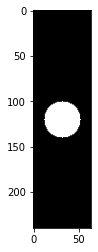

In [5]:
plt.imshow(data[0, :, 64, 32:96], cmap='gray', vmax=1, vmin=0)

In [6]:
class Emission(nn.Module):
    def __init__(self, mu_z, sig_z, log_ez0):
        super().__init__()
        self.mu_z     = mu_z
        self.sig_z    = sig_z
        self.log_ez0  = log_ez0
        #self.mu_z_    = mu_z.item()
        #self.sig_z_   = sig_z.item()
        #self.logn_ppf = lognorm.ppf([0.99], 1,
        #                    loc=self.mu_z_, scale=self.sig_z_)[0]
        
    def sample(self, x):
        b = x.shape[0]
        pz0  = dist.LogNormal(loc   = self.mu_z.view( b, 1, 1, 1, 1).expand(*x.shape),
                              scale = self.sig_z.view(b, 1, 1, 1, 1).expand(*x.shape),)
        x    = x * pz0.sample().to(x.device)
        x    = torch.clip(x, min=0, max=1)
        #x    = x / self.logn_ppf
        return x

    def forward(self, x):
        x = x * torch.exp(self.log_ez0)
        return x


class Intensity(nn.Module):
    def __init__(self, gamma, image_size, initial_depth, voxel_size, scale,
                 device):
        super().__init__()
        init_d = initial_depth
        im_z,  \
        im_x,  \
        im_y   = image_size
        end_d  = im_z * voxel_size * scale
        depth  = init_d \
               + torch.linspace(0, end_d, im_z,).view(-1,1,1,).to(device)
        _intensity = torch.exp(-2 * depth * gamma) # gamma = 0.005
        self._intensity = _intensity.expand(image_size)

    def forward(self, x):
         x = x * self.intensity
         return x

    @property
    def intensity(self):
        return self._intensity


class Blur(nn.Module):
    def __init__(self, z, x, y, log_bet_z, log_bet_xy, log_alpha, scale, device,
                 psf_mode:str="double_exp"):
        super().__init__()
        self.log_bet_z   = log_bet_z
        self.log_bet_xy  = log_bet_xy
        self.log_alpha   = log_alpha
        self.zscale, \
        self.xscale, \
        self.yscale  = scale
        self.z       = z
        self.x       = x
        self.y       = y
        self.device  = device
        self.zd      = self.distance(z)
        self.dp      = self.gen_distance_plane(xlen=x, ylen=y)
        self.mode    = psf_mode
        bet_xy       = torch.exp(self.log_bet_xy)
        bet_z        = torch.exp(self.log_bet_z )
        alpha        = torch.exp(self.log_alpha )
        self.psf     = self.gen_psf(bet_xy, bet_z, alpha).to(device)
        self.z_pad   = (z - self.zscale + 1) // 2
        self.x_pad   = (x - self.xscale + 1) // 2
        self.y_pad   = (y - self.yscale + 1) // 2
        self.stride  = (self.zscale, self.xscale, self.yscale)
    
    def forward(self, x):
        x_shape = x.shape
        bet_xy  = torch.exp(self.log_bet_xy)
        bet_z   = torch.exp(self.log_bet_z )
        alpha   = torch.exp(self.log_alpha )
        psf = self.gen_psf(bet_xy, bet_z, alpha).to(self.device)
        _x   = F.conv3d(input   = x                                    ,
                        weight  = psf                                  ,
                        stride  = self.stride                          ,
                        padding = (self.z_pad, self.x_pad, self.y_pad,),)
        batch = _x.shape[0]
        x = torch.empty(size=(*x_shape[:2], *_x.shape[2:])).to(self.device)
        for b in range(batch):
                x[b, 0] = _x[b, b]
        return x

    def gen_psf(self, bet_xy, bet_z, alpha):
        if bet_xy.shape:
            b = bet_xy.shape[0]
        else:
            b = 1
        if self.mode == "student_t":
            psf_lateral = self.gen_2dstudent_t(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dstudent_t(self.zd, bet_z , b)[:, None,    :, None, None]
            psf = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial))
        if self.mode == "gaussian" or self.mode == "double_exp":
            psf_lateral = self.gen_2dnorm(self.dp, bet_xy, b)[:, None, None,    :,    :]
            psf_axial   = self.gen_1dnorm(self.zd, bet_z , b)[:, None,    :, None, None]
            psf  = torch.exp(torch.log(psf_lateral) + torch.log(psf_axial)) # log-sum-exp technique
            if self.mode == "gaussian":
                pass
            elif self.mode == "double_exp":
                if not alpha.shape:
                    alpha = alpha.unsqueeze(0)
                psf  = self.gen_double_exp_dist(psf, alpha[:, None, None, None, None],)
        psf = psf / torch.sum(psf)
        return psf

    def _init_distance(self, length):
        return torch.zeros(length)

    def _distance_from_center(self, index, length):
        return abs(index - length // 2)

    def distance(self, length):
        distance = torch.zeros(length)
        for idx in range(length):
            distance[idx] = self._distance_from_center(idx, length)
        return distance.to(self.device)

    def gen_distance_plane(self, xlen, ylen):
        xd = self.distance(xlen)
        yd = self.distance(ylen)
        xp = xd.expand(ylen, xlen)
        yp = yd.expand(xlen, ylen).transpose(1, 0)
        dp = xp ** 2 + yp ** 2
        return dp.to(self.device)

    def gen_2dnorm(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  distance_plane / bet_xy ** 2
        normterm = (torch.pi * 2) * (bet_xy ** 2)
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_1dnorm(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  distance ** 2 / bet_z ** 2
        normterm = (torch.pi * 2) ** 0.5 * bet_z
        norm     = torch.exp(-d_2 / 2) / normterm
        return norm

    def gen_2dstudent_t(self, distance_plane, bet_xy, b):
        distance_plane = distance_plane.expand(b, *distance_plane.shape)
        bet_xy = bet_xy.view(b, 1, 1).expand(*distance_plane.shape)
        d_2      =  (distance_plane / bet_xy + 1) ** -((bet_xy + 1) / 2)
        normterm = torch.exp(S.gammaln((bet_xy + 1) / 2) - S.gammaln(bet_xy / 2)) / (torch.pi * bet_xy) ** 0.5
        norm     = normterm * d_2 
        return norm
    
    def gen_1dstudent_t(self, distance, bet_z, b):
        distance = distance.expand(b, *distance.shape)
        bet_z = bet_z.view(b, 1).expand(*distance.shape)
        d_2      =  (distance ** 2 / bet_z + 1) ** -((bet_z + 1) / 2)
        normterm = torch.exp(S.gammaln((bet_z + 1) / 2) - S.gammaln(bet_z / 2)) / (torch.pi * bet_z) ** 0.5
        norm     = normterm * d_2 
        return norm

    def gen_double_exp_dist(self, norm, alpha,):
        pdf  = 1. - torch.exp(-alpha * norm)
        return pdf


class Noise(nn.Module):
    def __init__(self, sig_eps):
        super().__init__()
        self.sig_eps = sig_eps

    def forward(self, x):
        return x
    
    def sample(self, x):
        b = x.shape[0]
        px = dist.Normal(loc   = x           ,
                         scale = self.sig_eps.view(b, 1, 1, 1, 1).expand(*x.shape).to(x.device))
        x  = px.rsample()
        x  = torch.clip(x, min=0, max=1)
        return x


class PreProcess(nn.Module):
    def __init__(self, min, max):
        super().__init__()
        self.min = min
        self.max = max

    def forward(self, x):
        x = torch.clip(x, min=self.min, max=self.max)
        x = (x - self.min) / (self.max - self.min)
        return x


class ImagingProcess(nn.Module):
    def __init__(self, device, params,
                 z, x, y, postmin=0., postmax=1.,
                 mode:str="train",dist="double_exp"):
        super().__init__()
        self.device = device
        self.z = z
        self.x = x
        self.y = y
        self.postmin = postmin
        self.postmax = postmax
        if mode == "train":
            self.mu_z   = torch.tensor(params["mu_z"])
            self.sig_z  = torch.tensor(params["sig_z"])
            self.log_ez0 = nn.Parameter((torch.tensor(params["mu_z"] + 0.5 * params["sig_z"] ** 2)).to(device), requires_grad=True)
            self.log_bet_z  = nn.Parameter(torch.tensor(params["log_bet_z" ]).to(device), requires_grad=True)
            self.log_bet_xy = nn.Parameter(torch.tensor(params["log_bet_xy"]).to(device), requires_grad=True)
            self.log_alpha  = nn.Parameter(torch.tensor(params["log_alpha" ]).to(device), requires_grad=True)
        elif mode == "dataset":
            self.mu_z    = nn.Parameter(torch.tensor(params["mu_z"  ]), requires_grad=False)
            self.sig_z   = nn.Parameter(torch.tensor(params["sig_z" ]), requires_grad=False)
            self.log_bet_z   = nn.Parameter(torch.tensor(params["log_bet_z" ]), requires_grad=False)
            self.log_bet_xy  = nn.Parameter(torch.tensor(params["log_bet_xy"]), requires_grad=False)
            self.log_alpha   = nn.Parameter(torch.tensor(params["log_alpha" ]), requires_grad=False)
        else:
            raise(NotImplementedError())
        scale = [params["scale"], 1, 1]
        self.emission   = Emission(mu_z    = self.mu_z ,
                                   sig_z   = self.sig_z,
                                   log_ez0 = self.log_ez0,)
        self.blur       = Blur(z           = z              ,
                               x           = x              ,
                               y           = y              ,
                               log_bet_z   = self.log_bet_z ,
                               log_bet_xy  = self.log_bet_xy,
                               log_alpha   = self.log_alpha ,
                               scale       = scale          ,
                               device      = device         ,
                               psf_mode    = dist   ,)
        self.noise      = Noise(torch.tensor(params["sig_eps"]))
        self.preprocess = PreProcess(min=postmin, max=postmax)

    def forward(self, x):
        x = self.emission(x)
        x = self.blur(x)
        x = self.preprocess(x)
        return x

    def sample(self, x):
        x = self.emission.sample(x)
        x = self.blur(x)
        x = self.noise.sample(x)                   
    
    def sample_from_params(self, x, params):
        if isinstance(params["scale"], torch.Tensor):
            z = int(params["scale"][0])
        else:
            z = params["scale"]
        scale = [z, 1, 1] ## use only one scale
        emission   = Emission(tt(params["mu_z"]), tt(params["sig_z"]))
        blur       = Blur(self.z, self.x, self.y,
                          tt(params["log_bet_z"]), tt(params["log_bet_xy"]),
                          tt(params["log_alpha"]), scale, self.device)
        noise      = Noise(tt(params["sig_eps"]))
        preprocess = PreProcess(min=self.postmin, max=self.postmax)
        x = emission.sample(x)
        x = blur(x)
        x = noise.sample(x)
        x = preprocess(x)
        return x

In [7]:
dirpath = "_beads_roi_extracted"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
beadslist
label = torch.load(beadslist[0], map_location="cuda").to(torch.float32)

In [8]:
loss_fn = nn.MSELoss()

def normalize(array):
    return array / torch.sum(array)

def train_loop(obj, model, label, optimizer, epoch):
    for _ in range(epoch):
        if obj.dim() == 4:
            obj = obj.unsqueeze(0)
        x = model(obj)
        if x.dim() == 5:
            x = x.squeeze(0)
        loss = loss_fn(x, label)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        log_ez0, bet_z, bet_xy, alpha = [i for i in model.parameters()]
        print(f'epoch {_}, loss {loss:.8f}, log_ez0 {log_ez0.item():.6f}, log_bet_xy {bet_xy.item():.6f}, log_bet_z {bet_z.item():.6f}, log_alpha {alpha.item():.6f}')if _ % 10 == 0 else 0
    return loss.item()

In [56]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(2.).item(),
          "log_bet_xy" : np.log(5.).item(),
          "log_alpha"  : np.log(2.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
for bead in beadslist[:-1]:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 1000)
    losses.append(loss)

beads_001_roi000
epoch 0, loss 0.00554006, log_ez0 0.210000, log_bet_xy 1.619261, log_bet_z 0.683148, log_alpha 0.693147
epoch 10, loss 0.00547717, log_ez0 0.108474, log_bet_xy 1.716128, log_bet_z 0.582646, log_alpha 0.693147
epoch 20, loss 0.00532868, log_ez0 -0.001181, log_bet_xy 1.801431, log_bet_z 0.478643, log_alpha 0.693147
epoch 30, loss 0.00494223, log_ez0 -0.118089, log_bet_xy 1.871463, log_bet_z 0.366942, log_alpha 0.693147
epoch 40, loss 0.00477747, log_ez0 -0.217231, log_bet_xy 1.926296, log_bet_z 0.259083, log_alpha 0.693147
epoch 50, loss 0.00473022, log_ez0 -0.271762, log_bet_xy 1.968851, log_bet_z 0.159460, log_alpha 0.693147
epoch 60, loss 0.00470130, log_ez0 -0.284512, log_bet_xy 2.003402, log_bet_z 0.065368, log_alpha 0.693147
epoch 70, loss 0.00466332, log_ez0 -0.271212, log_bet_xy 2.033621, log_bet_z -0.028348, log_alpha 0.693147
epoch 80, loss 0.00461704, log_ez0 -0.247079, log_bet_xy 2.061894, log_bet_z -0.126098, log_alpha 0.693147
epoch 90, loss 0.00456654, log

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(2.).item(),
          "log_bet_xy" : np.log(5.).item(),
          "log_alpha"  : np.log(2.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
print(losses)

beads_001_roi000
epoch 0, loss 0.00554006, log_ez0 0.210000, log_bet_xy 1.619261, log_bet_z 0.683148, log_alpha 0.693147
epoch 10, loss 0.00547717, log_ez0 0.108474, log_bet_xy 1.716128, log_bet_z 0.582646, log_alpha 0.693147
epoch 20, loss 0.00532868, log_ez0 -0.001181, log_bet_xy 1.801431, log_bet_z 0.478643, log_alpha 0.693147
epoch 30, loss 0.00494223, log_ez0 -0.118089, log_bet_xy 1.871463, log_bet_z 0.366942, log_alpha 0.693147
epoch 40, loss 0.00477747, log_ez0 -0.217231, log_bet_xy 1.926296, log_bet_z 0.259083, log_alpha 0.693147
epoch 50, loss 0.00473022, log_ez0 -0.271762, log_bet_xy 1.968851, log_bet_z 0.159460, log_alpha 0.693147
epoch 60, loss 0.00470130, log_ez0 -0.284512, log_bet_xy 2.003402, log_bet_z 0.065368, log_alpha 0.693147
epoch 70, loss 0.00466332, log_ez0 -0.271212, log_bet_xy 2.033621, log_bet_z -0.028348, log_alpha 0.693147
epoch 80, loss 0.00461704, log_ez0 -0.247079, log_bet_xy 2.061894, log_bet_z -0.126098, log_alpha 0.693147
epoch 90, loss 0.00456654, log

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(2.).item(),
          "log_bet_xy" : np.log(5.).item(),
          "log_alpha"  : np.log(2.).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
torch.autograd.set_detect_anomaly(True)
losses = []
beadslist.pop(1)
beadslist.pop(1)
beadslist.pop(-1)
for bead in beadslist:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                ,
                          mode         = "train"          ,
                          dist         = "student_t"      ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
print(losses)

beads_001_roi000
epoch 0, loss 0.00383066, log_ez0 0.210000, log_bet_xy 1.619258, log_bet_z 0.683148, log_alpha 0.693147
epoch 10, loss 0.00375230, log_ez0 0.108683, log_bet_xy 1.716193, log_bet_z 0.582599, log_alpha 0.693147
epoch 20, loss 0.00357845, log_ez0 -0.000900, log_bet_xy 1.801303, log_bet_z 0.478052, log_alpha 0.693147
epoch 30, loss 0.00311660, log_ez0 -0.119433, log_bet_xy 1.870981, log_bet_z 0.364697, log_alpha 0.693147
epoch 40, loss 0.00289374, log_ez0 -0.223631, log_bet_xy 1.925334, log_bet_z 0.255448, log_alpha 0.693147
epoch 50, loss 0.00281938, log_ez0 -0.290908, log_bet_xy 1.967153, log_bet_z 0.155978, log_alpha 0.693147
epoch 60, loss 0.00279118, log_ez0 -0.321624, log_bet_xy 2.000457, log_bet_z 0.064932, log_alpha 0.693147
epoch 70, loss 0.00276720, log_ez0 -0.326019, log_bet_xy 2.028736, log_bet_z -0.021732, log_alpha 0.693147
epoch 80, loss 0.00273876, log_ez0 -0.315209, log_bet_xy 2.054382, log_bet_z -0.108154, log_alpha 0.693147
epoch 90, loss 0.00270623, log

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(2. ).item(),
          "log_alpha"  : np.log(2. ).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
losses = []
for bead in beadslist[:-1]:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                , 
                          mode         = "train"          ,
                          dist         = "double_exp"      ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00244035, log_ez0 0.230000, log_bet_xy 0.703104, log_bet_z 3.005732, log_alpha 0.702087
epoch 10, loss 0.00224766, log_ez0 0.328778, log_bet_xy 0.802539, log_bet_z 3.104708, log_alpha 0.788460
epoch 20, loss 0.00211905, log_ez0 0.420266, log_bet_xy 0.901236, log_bet_z 3.197446, log_alpha 0.864096
epoch 30, loss 0.00206031, log_ez0 0.494140, log_bet_xy 0.998293, log_bet_z 3.274712, log_alpha 0.920072
epoch 40, loss 0.00204913, log_ez0 0.539633, log_bet_xy 1.092117, log_bet_z 3.324852, log_alpha 0.951149
epoch 50, loss 0.00205084, log_ez0 0.554560, log_bet_xy 1.180427, log_bet_z 3.342176, log_alpha 0.962009
epoch 60, loss 0.00205009, log_ez0 0.549561, log_bet_xy 1.261195, log_bet_z 3.336080, log_alpha 0.962167
epoch 70, loss 0.00204890, log_ez0 0.539056, log_bet_xy 1.333504, log_bet_z 3.324599, log_alpha 0.964281
epoch 80, loss 0.00204875, log_ez0 0.532652, log_bet_xy 1.397932, log_bet_z 3.317821, log_alpha 0.972495
epoch 90, loss 0.00204872, log_ez0 0.53

[0.002048630267381668,
 0.019659724086523056,
 0.013229059986770153,
 0.007774370722472668,
 0.006031540688127279,
 0.0017756478628143668,
 0.0021561486646533012,
 0.0035222559235990047,
 0.0013606399297714233,
 0.0008458431693725288,
 0.0027012196369469166,
 0.0019234021892771125,
 0.0012236637994647026]

In [63]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
obj = data.to(device)
scale_factor = [10, 1, 1]
z = 161
x = 3
y = 3
params = {"mu_z"       : 0.2    ,
          "sig_z"      : 0.2    ,
          "log_bet_z"  : np.log(20.).item(),
          "log_bet_xy" : np.log(2. ).item(),
          "log_alpha"  : np.log(2. ).item(),
          "sig_eps"    : 0.01   ,
          "scale"      : 10
          }
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
losses = []
for bead in beadslist[:-1]:
    dirpath = "_beads_roi_extracted"
    label = torch.load(bead, map_location="cuda").to(torch.float32)
    label = (torch.clip(label, min=0.1, max=1.) - 0.1) / (1.0 - 0.1)
    blur = ImagingProcess(device       = device           ,
                          params       = params           ,
                          z            = z                ,
                          x            = x                ,
                          y            = y                , 
                          mode         = "train"          ,
                          dist         = "double_exp"      ,
                          )
    optimizer = torch.optim.Adam(blur.parameters(), lr=1e-2)
    print(bead[21:-3])
    loss = train_loop(obj, blur, label, optimizer, 100)
    losses.append(loss)
losses

beads_001_roi000
epoch 0, loss 0.00107995, log_ez0 0.230000, log_bet_xy 0.703102, log_bet_z 3.005731, log_alpha 0.700239
epoch 10, loss 0.00103332, log_ez0 0.323047, log_bet_xy 0.802581, log_bet_z 3.090480, log_alpha 0.755557
epoch 20, loss 0.00103466, log_ez0 0.362941, log_bet_xy 0.901082, log_bet_z 3.126953, log_alpha 0.779964
epoch 30, loss 0.00103180, log_ez0 0.341855, log_bet_xy 0.994647, log_bet_z 3.106648, log_alpha 0.781541
epoch 40, loss 0.00103166, log_ez0 0.324915, log_bet_xy 1.078936, log_bet_z 3.091627, log_alpha 0.782092
epoch 50, loss 0.00103124, log_ez0 0.333450, log_bet_xy 1.153930, log_bet_z 3.099514, log_alpha 0.786610
epoch 60, loss 0.00103121, log_ez0 0.339196, log_bet_xy 1.222084, log_bet_z 3.104748, log_alpha 0.790069
epoch 70, loss 0.00103108, log_ez0 0.334664, log_bet_xy 1.284721, log_bet_z 3.100469, log_alpha 0.791172
epoch 80, loss 0.00103104, log_ez0 0.334136, log_bet_xy 1.342284, log_bet_z 3.100096, log_alpha 0.792650
epoch 90, loss 0.00103100, log_ez0 0.33

[0.00103097315877676,
 0.01614302396774292,
 0.009922204539179802,
 0.005684983916580677,
 0.003949444275349379,
 0.0009082615142688155,
 0.0012308855075389147,
 0.0014018167275935411,
 0.000529001874383539,
 0.00023188971681520343,
 0.001398470951244235,
 0.0010286904871463776,
 0.0004144349950365722]